In [0]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from mlxtend.regressor import StackingCVRegressor


## Customer Churn:
Costumer churn or costumer atrition is the loss of the costumers. It is a key business metric for  Banks, telephone service companies, Internet service providers.



### Task1_Dataset structure:
The dataset is for a telecomunication company with more than 7000 entries.For each costumer we have 19 features plus a column stating if the costumers have churned or not.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset =pd.read_csv('/content/drive/My Drive/FindLab/churn_dataset.csv')

In [0]:
dataset.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [0]:
print('checking for anomalies in typs of features: \n\n\n ',dataset.dtypes)


checking for anomalies in typs of features: 


  customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [0]:
df = dataset.copy()
df = df.drop(columns=['customerID'])# removing the costumer ID as it has no value

### Task1_Which column(s) have null values?

At first glance isnul() shows an unusual case of no null values.

I observe that TotalCharges feature is an object type even though it should be in numeric. Using pandas to_numeric function we make the conversation. However we encounter an error **'
ValueError: Unable to parse string " " at position 488'**. This shows that there are null values here. So I add **errors='coerce'** to the function.

This time adding all the null values for the dataframe results in 11 null values in 'TotalCharges'

In [0]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print('cheching for null values:\n\n' ,df.isnull().sum())

bool_series = pd.isnull(df["TotalCharges"])  
# total charges that have null value 
df[bool_series]  


cheching for null values:

 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


### task_1 Which percentage of null values dataset has?Replace null values with best candidates:

0.15 percent is the percentage of null values.


Since there are so few of the values I can simply remove them and it will not effect the training accuracy. 

However, looking farther into these cases show that all of them have 2 year contracts , so it can be reasoned that maybe it is the start of their contract and they havent reached a billing cycle yet. Placing the first month charge as their total charge I believe is a safe bet. 


In [0]:
print('percent missing:%',len(df[bool_series])/len(df) *100)
df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)
## 11 of total charges have NaN values which I will replace with month charges


percent missing:% 0.1561834445548772


Printing statistics for monthly charges to observe if there is any obvious correlation between churn and monthly charges. We see that Churn costumers have higher average monthly charge, which makes sense.


In [0]:
df['Churn'].replace(to_replace='Yes',value=1, inplace=True)
df['Churn'].replace(to_replace='No',value=0, inplace=True)
print('Minimum value in monthly charges:', df['MonthlyCharges'].min())
print('Maximum value in monthly charges:', df['MonthlyCharges'].max())
print('Mean monthly charges of Churn Customers:', round(df[df['Churn'] != 0]['MonthlyCharges'].mean() ,2))
print('Mean monthly charges of Non-Churn Customers:', round(df[df['Churn'] == 0]['MonthlyCharges'].mean(),2))


Minimum value in monthly charges: 18.25
Maximum value in monthly charges: 118.75
Mean monthly charges of Churn Customers: 74.44
Mean monthly charges of Non-Churn Customers: 61.27


In [0]:
# I chose labelEncoder instead of get_dummie method as there will be so many columns
from sklearn.preprocessing import LabelEncoder
def encoder(dataframe_value):
    if dataframe_value.dtype=='object':
        dataframe_value= LabelEncoder().fit_transform(dataframe_value)
    return dataframe_value
df = df.apply(lambda x: encoder(x))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Charting out the correlation coeficient between features and churn. We can observe again that Monthly charges and suprisingly paperless billling lead the charge for having the highest correlation to churn!


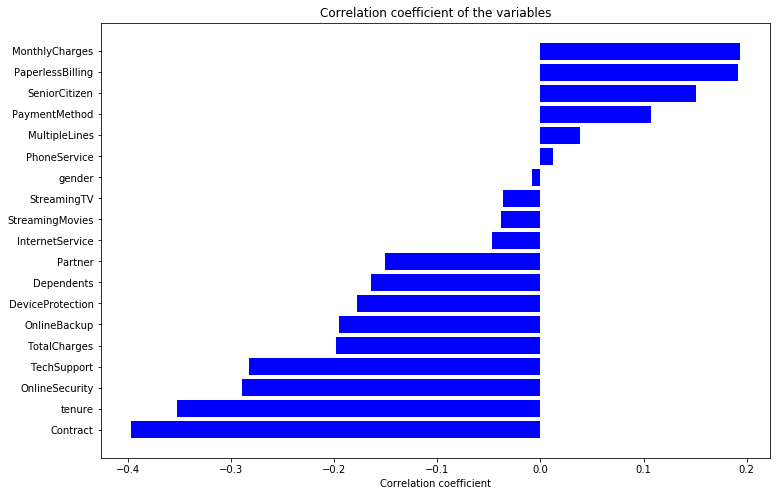

In [0]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
labels = []
values = []
features = [f for f in df.columns]
features.remove('Churn')
for col in features:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df['Churn'].values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels,
                        'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [0]:
corr_df.iloc[::-1].head(5)



,col_labels,corr_values
17,MonthlyCharges,0.193356
15,PaperlessBilling,0.191825
1,SeniorCitizen,0.150889
16,PaymentMethod,0.107062
6,MultipleLines,0.038037


###  What is your strategy for feature selection? (backward, forward, mixed?)

Drawing the correlation between every feature we  see if there is any high collinearity between two or more features. Tenure, montly charges, contract, total charges are all highly correlated.


I would remove one of these feature but I’m not confident enough that they are too correlated that they negatively effect the final result. 
Therefore, this would be an example of **backwards** elimination but I’ve chosen not to do it.

Also I am planing to use XGboost which has a feature importance vector,  which will be an example of **Forward Selection method**.


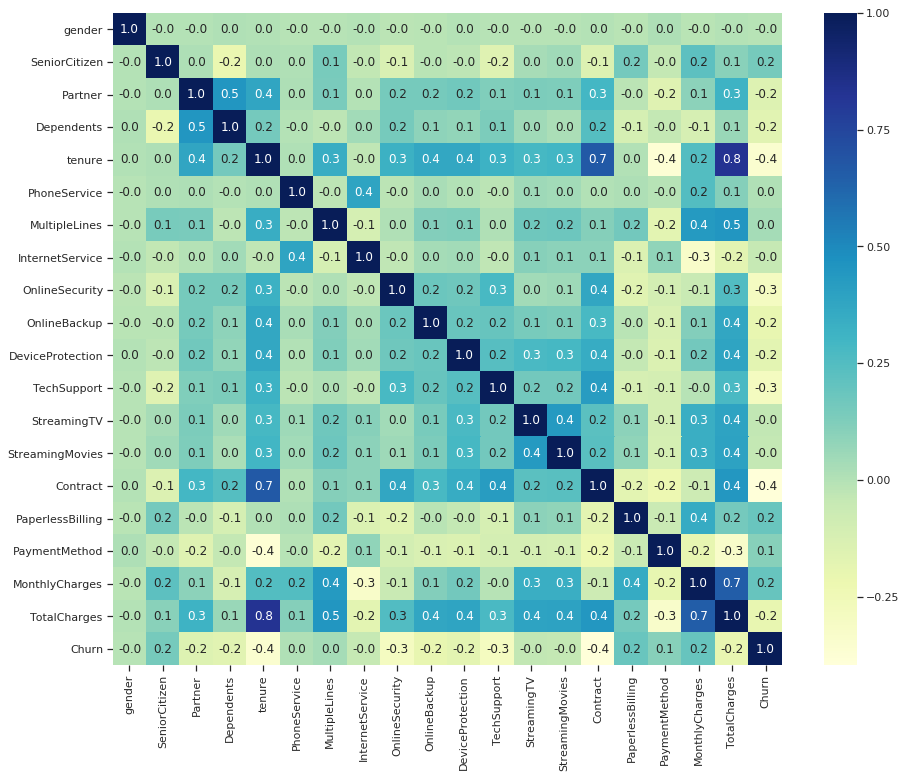

In [0]:
plt.figure(figsize = (15, 12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, fmt=".1f")
plt.show()

In [0]:
print(round(df['Churn'].value_counts(normalize=True) * 100,2))
# we observe that 26.54% of the costumers have churned

0    73.46
1    26.54
Name: Churn, dtype: float64


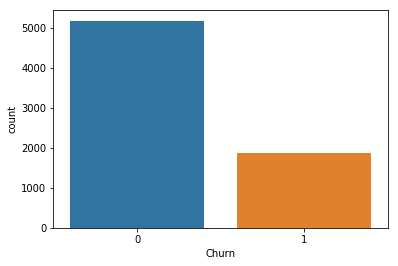

In [0]:
ax = sns.countplot(x="Churn", data=df)


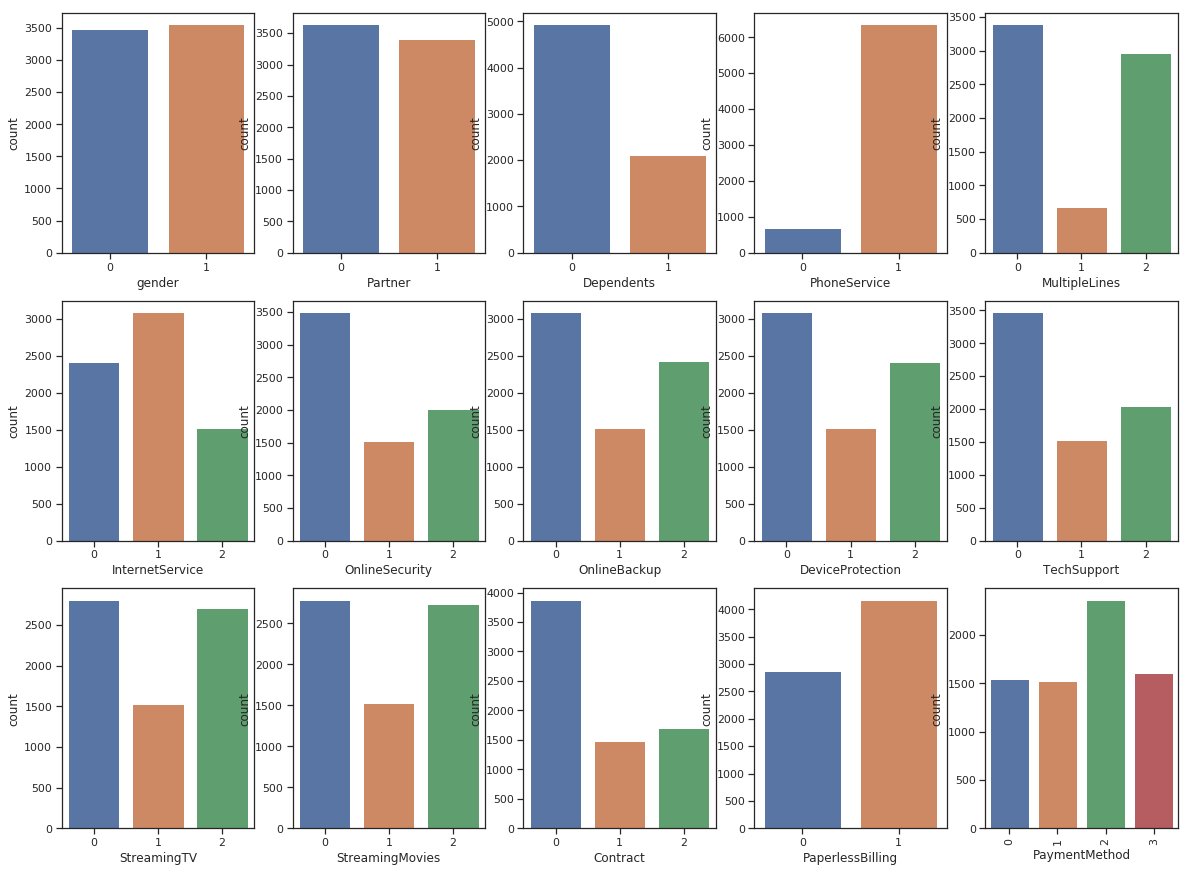

In [0]:

sns.set(style="ticks", color_codes=True)
fig, axes = plt.subplots(nrows = 3,ncols = 5,figsize = (20,15))
sns.countplot(x = "gender", data = df, ax=axes[0][0])
sns.countplot(x = "Partner", data = df, ax=axes[0][1])
sns.countplot(x = "Dependents", data = df, ax=axes[0][2])
sns.countplot(x = "PhoneService", data = df, ax=axes[0][3])
sns.countplot(x = "MultipleLines", data = df, ax=axes[0][4])
sns.countplot(x = "InternetService", data = df, ax=axes[1][0])
sns.countplot(x = "OnlineSecurity", data = df, ax=axes[1][1])
sns.countplot(x = "OnlineBackup", data = df, ax=axes[1][2])
sns.countplot(x = "DeviceProtection", data = df, ax=axes[1][3])
sns.countplot(x = "TechSupport", data = df, ax=axes[1][4])
sns.countplot(x = "StreamingTV", data = df, ax=axes[2][0])
sns.countplot(x = "StreamingMovies", data = df, ax=axes[2][1])
sns.countplot(x = "Contract", data = df, ax=axes[2][2])
sns.countplot(x = "PaperlessBilling", data = df, ax=axes[2][3])
ax = sns.countplot(x = "PaymentMethod", data = df, ax=axes[2][4])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show(fig)

Plotting the distribution of monthly and total charges over churn or no churn costumers. 

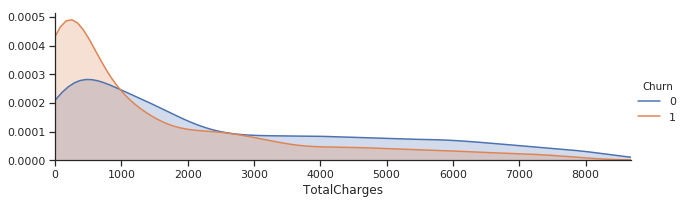

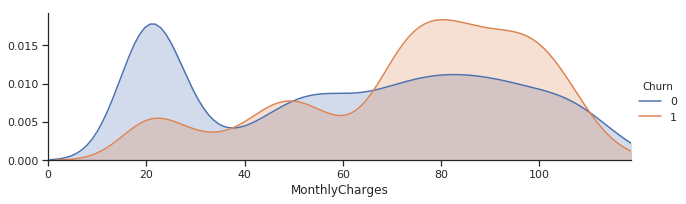

In [0]:
ex = sns.FacetGrid(df, hue = "Churn", aspect = 3)
ex.map(sns.kdeplot,"TotalCharges",shade= True)
ex.set(xlim=(0, df["TotalCharges"].max()))
ex.add_legend()

ex = sns.FacetGrid(df, hue = "Churn", aspect = 3)
ex.map(sns.kdeplot,"MonthlyCharges",shade= True)
ex.set(xlim=(0, df["MonthlyCharges"].max()))
ex.add_legend()

### task_2 Which features you selected and why?

I have chosen to keep all the features and only eliminate the costumerID. Tree-based and GBM models have an innate feature of being robust to correlated features.Also gradient boosting models have built in feature selection.

Also dropping features will leave room for the tree to use one more variable in its trees. Due to the fact I am opening room for one more variable, it is possible to end up performing poorer.


I would use PCA if TSNE if the models weren't performing this well.


In [0]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [0]:
# spliting our training data to tsting and training set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 42)

DecisionTree =DecisionTreeClassifier()
RandomForest=RandomForestClassifier() 
NaiveBayes= GaussianNB()
KNeighbours=KNeighborsClassifier()
SVM=SVC()
LogisticRegression=sk.linear_model.LogisticRegression()
AdaBoostClassifier =AdaBoostClassifier()
GradientBoosting= GradientBoostingClassifier()
XGB= XGBClassifier()
LDA = LinearDiscriminantAnalysis() 
QDA = QuadraticDiscriminantAnalysis()


In [0]:
import warnings
warnings.filterwarnings('ignore')
DecisionTree.fit(X_train, y_train)
RandomForest.fit(X_train, y_train)
NaiveBayes.fit(X_train, y_train)
KNeighbours.fit(X_train, y_train)
SVM.fit(X_train, y_train)
LogisticRegression.fit(X_train, y_train)
AdaBoostClassifier.fit(X_train, y_train)
GradientBoosting.fit(X_train, y_train)
XGB.fit(X_train, y_train)
LDA.fit(X_train, y_train)
QDA.fit(X_train, y_train)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [0]:
classifiers =[DecisionTree,RandomForest, NaiveBayes, KNeighbours, SVM, LogisticRegression,AdaBoostClassifier,
             GradientBoosting,XGB,LDA,QDA]
def model_cofusion_accuracy_report(classifier):
    predictions = classifier.predict(X_test)  
    report = classification_report(y_test,predictions)
    accuracy= accuracy_score(y_test, predictions)
    print(classifier)
    print ("Accuracy   Score : ",accuracy_score(y_test, predictions))
    print ("\n Classification report : \n",classification_report(y_test, predictions))

for classifier in classifiers:

    model_cofusion_accuracy_report(classifier)
    

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Accuracy   Score :  0.7288857345635202

 Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1036
           1       0.49      0.50      0.50       373

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease

Since the logistic regression model is very sensetive to correlated features and Xgboost and gradient boosting are not, I can infer that similar accuracy and f1 score between these models justify not removing any of the correlated features. Meaning that features still had some importance. This will be an example of backward elimination 

### Explain why you have selected that specific model

Models with highest f1_score, recall, percision and accuracty score are selected and are placed in a Voting classifer to achieve the highest possible accuracy. 

In [0]:
from sklearn.ensemble import VotingClassifier
Voting_classifier =  VotingClassifier(estimators = [
    ('LDA', LDA), ('XGB',XGB), ('LogisticRegression', LogisticRegression),
    ('GradientBoosting', GradientBoosting)]
                                      , voting = 'soft')

In [0]:
Voting_classifier.fit(X_train, y_train)
model_cofusion_accuracy_report(Voting_classifier)

VotingClassifier(estimators=[('LDA',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                                         shrinkage=None,
                                                         solver='svd',
                                                         store_covariance=False,
                                                         tol=0.0001)),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            mi